<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

Mission and performance figures broadly based on the Jetstream 3100 series, 19-seat regional twin turboprop.

<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/gnfla.png" width="40%" align="right">

# Constraint Analysis in ADRpy - a Twin Turboprop Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

In [14]:
designatm = at.Atmosphere() # ISA standard day

In [15]:
designbrief = {'rwyelevation_m':0, 'groundrun_m':1600, # <- T/O (balanced field, ISA, no slope/wind)
               
               'stloadfactor': 2, 'turnalt_m': 6400, 'turnspeed_ktas': 220, # <- Turn requirements
               
               'climbalt_m': co.feet2m(5000), 'climbspeed_kias': 112, 'climbrate_fpm': 2100, # <- manual + Angland
               
               'cruisealt_m': 6400, 'cruisespeed_ktas': 295, 'cruisethrustfact': 1, # full power (typical of normal ops, not SAR speed
               
               'servceil_m': 7600, 'secclimbspd_kias': 115, # <- Service ceiling requirements
               
               'vstallclean_kcas': 98 + 5} # <- at MTOW, from 637 AFM Section 4 + calibration error from Angland report


In [16]:
TOW_kg = 7059 # MTOW of G-NFLA, airline operated examples generally lighter, CofA has MTOW = 6,600kg, max usable fuel 1,366kg.

In [17]:
designdefinition = {'aspectratio':10, 'sweep_le_deg':3, 'sweep_mt_deg':0,          
                    'weightfractions': {'turn': 0.9, 'climb': 0.78, 'cruise': 0.8, 'servceil': 0.9},
                    'weight_n': co.kg2n(TOW_kg)}

designpropulsion = "turboprop"

In [18]:
designperformance = {'CDTO': 0.072 + 0.056 * 0.523 ** 2, 'CLTO': 0.523, 'CLmaxTO': 1.81, 'CLmaxclean': 1.61, 'mu_R': 0.03,
                    'CDminclean': 0.0376,
                    'etaprop': {'take-off': 0.6, 'climb': 0.75, 'cruise': 0.9, 'turn': 0.8, 'servceil': 0.8}}


In [19]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)


### Power required - basic constraint diagram

In [20]:
P_JS_hp = 2 * 940 * 0.91 # assuming 9% airframe integration loss
print("JS31 total useful power: ", P_JS_hp, "shp")

JS31 total useful power:  1710.8 shp


In [21]:
wslist_pa = np.arange(2000, 5000, 2.5)

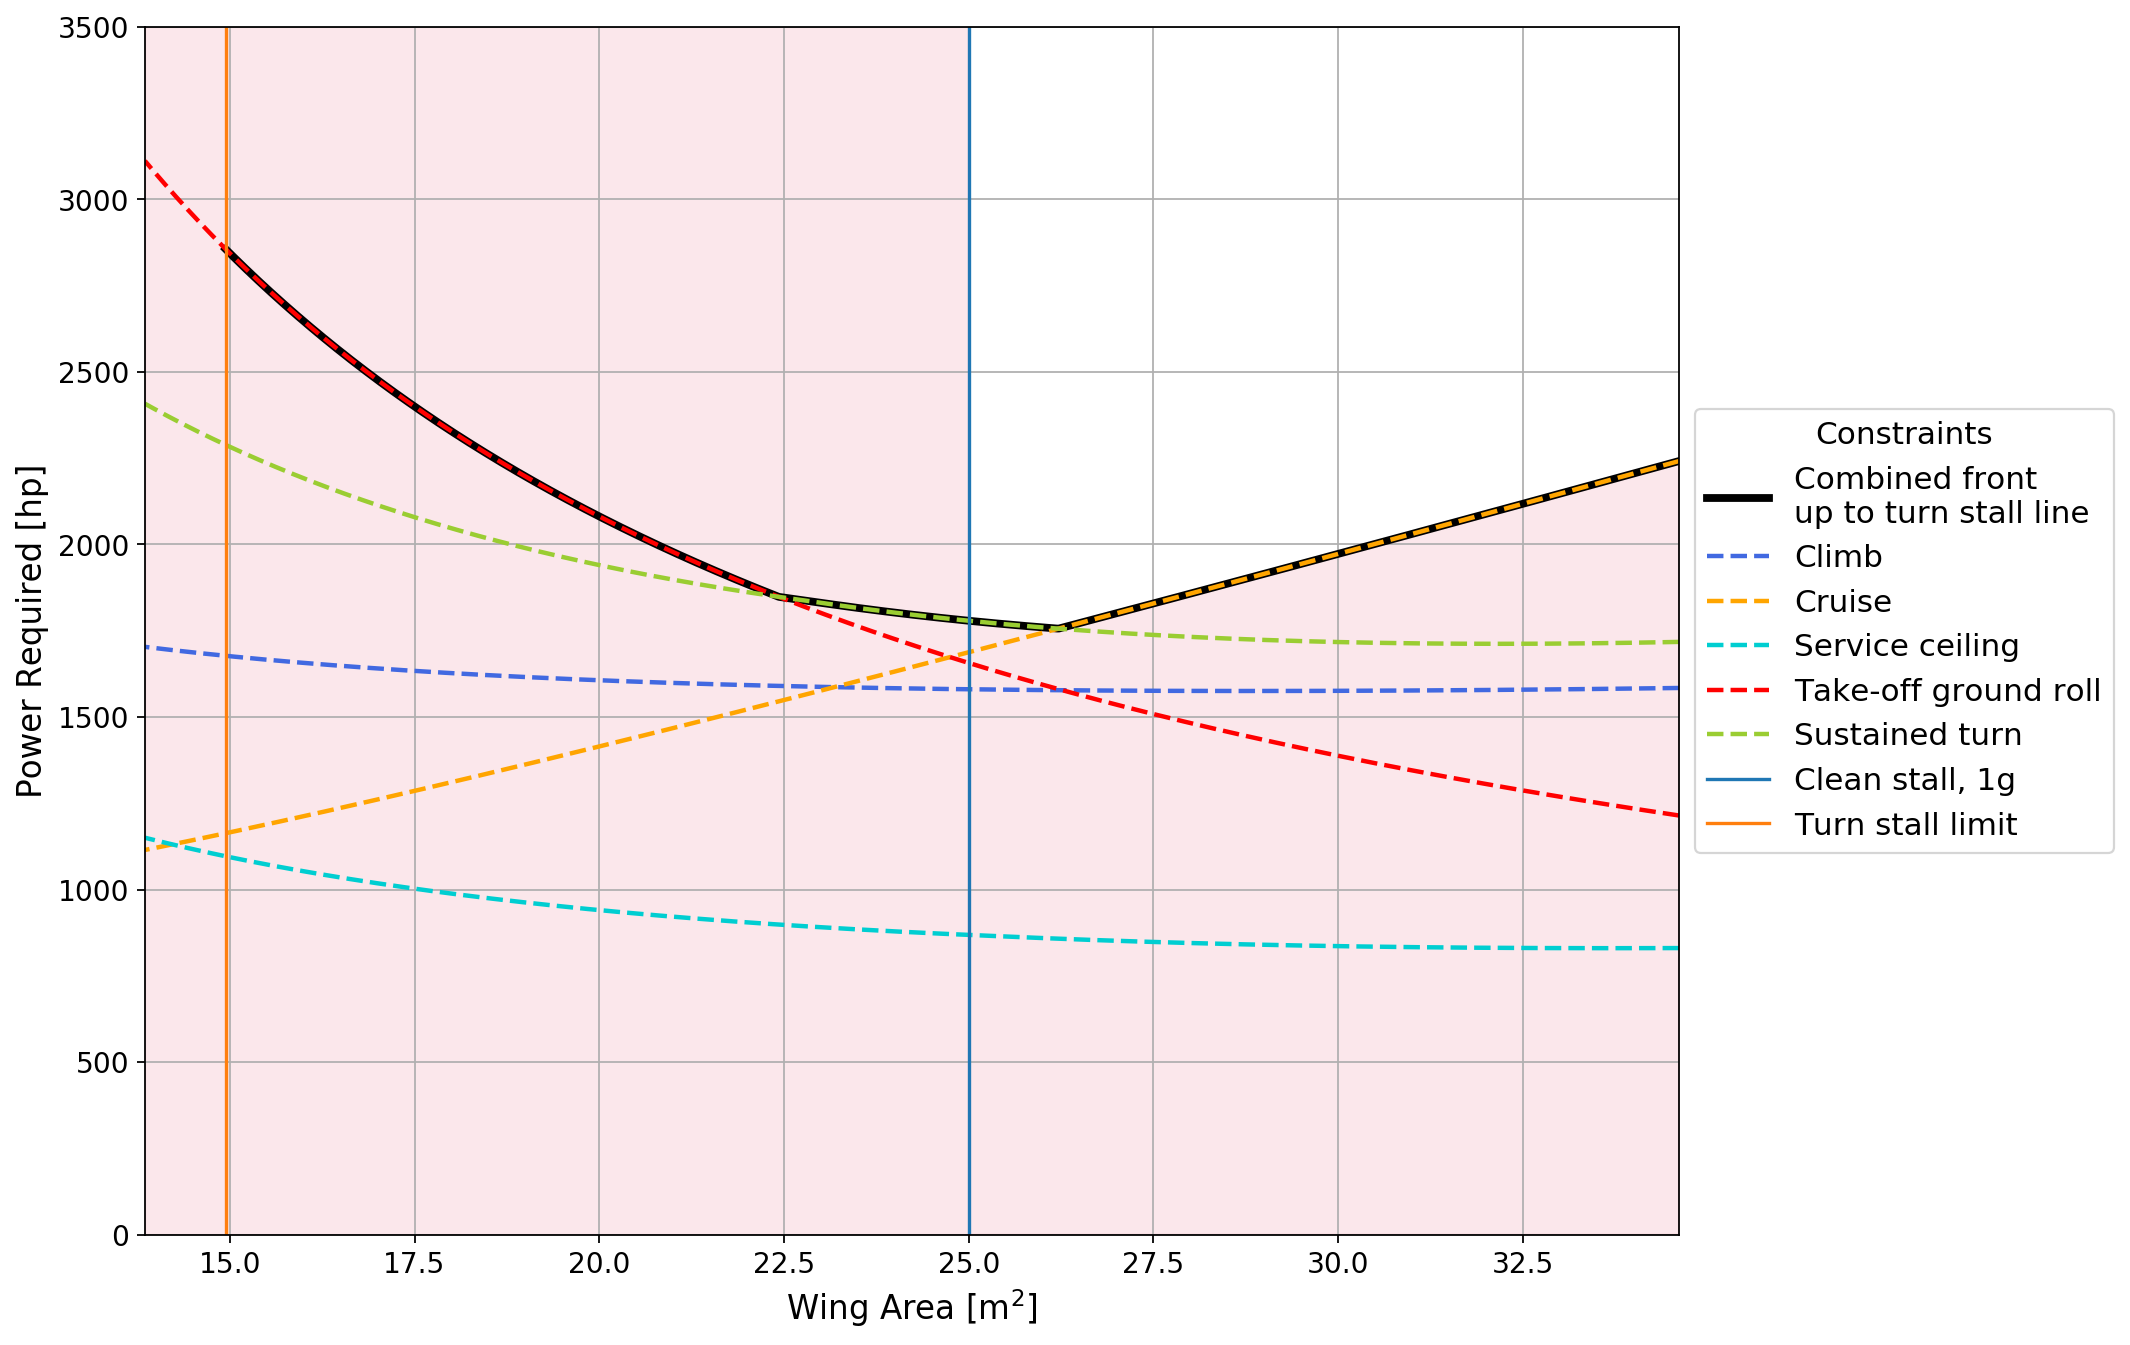

In [22]:
a = concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='combined', y_var='p_hp', x_var='s_m2', y_lim=3500)

### Further analysis through  `pwrequired`

In [23]:
preq = concept.powerrequired(wslist_pa, TOW_kg) 

Smin_m2 = concept.smincleanstall_m2(TOW_kg)

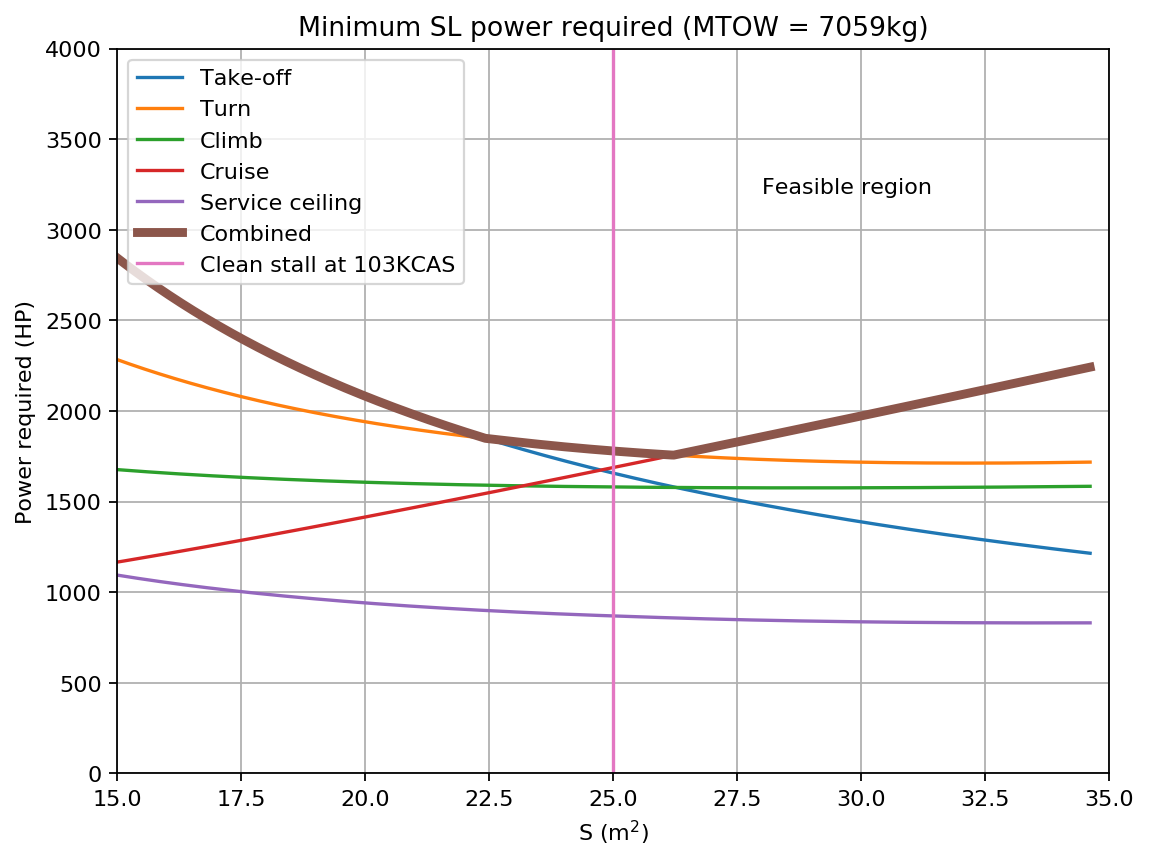

In [24]:
wingarea_m2 = co.kg2n(TOW_kg) / wslist_pa # x axis

plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams['figure.dpi'] = 160

plt.plot(wingarea_m2, preq['take-off'],  label = 'Take-off')
plt.plot(wingarea_m2, preq['turn'], label = 'Turn')
plt.plot(wingarea_m2, preq['climb'], label = 'Climb')
plt.plot(wingarea_m2, preq['cruise'], label = 'Cruise')
plt.plot(wingarea_m2, preq['servceil'], label = 'Service ceiling')

combplot = plt.plot(wingarea_m2, preq['combined'], label = 'Combined')

plt.setp(combplot, linewidth=4)

stall_label = 'Clean stall at ' + str(designbrief['vstallclean_kcas']) + 'KCAS'

plt.plot([Smin_m2, Smin_m2], [0, 4000], label = stall_label)

legend = plt.legend(loc='upper left')

plt.ylabel("Power required (HP)")
plt.xlabel("S (m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(15,35)
plt.ylim(0, 4000)
plt.grid(True)
plt.text(28, 3200, 'Feasible region')
plt.show()